<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/master/nb/HOD_HMC_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling HOD parameters by Hamiltonian Monte-Carlo

Authors:
 - [@bhorowitz](https://github.com/bhorowitz) (Ben Horowitz)
 - [@EiffL](https://github.com/EiffL) (Francois Lanusse)


This notebook demonstrate sampling HOD parameters using HMC over a stochastically sampled galaxy catalogs.




## Setup

Here we quickly install our dependencies, and download the reference halotools 
catalog from the Bolshoi simulation. This takes under a minute.

In [1]:
!pip install --quiet -i https://test.pypi.org/simple/ halotools
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/DHOD.git

     |████████████████████████████████| 14.0 MB 172 kB/s 
     |████████████████████████████████| 163 kB 7.5 MB/s 


In [ ]:
!download_initial_halocat.py

In [1]:
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

In [48]:
import tensorflow as tf
import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
from diffhod.utils import cic_paint
from diffhod.mock_observables.pk import Power_Spectrum

In [3]:
# A few hyper parameters
temperature=0.02
batch_size=2
max_sat=64
box_size = 128.

In [4]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos, and restricting the size of the catalog
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < box_size]
halo_table = halo_table[halo_table['halo_y'] < box_size]
halo_table = halo_table[halo_table['halo_z'] < box_size]
print("Size of halo catalog", len(halo_table))

# Convert table to tensors
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

Size of halo catalog 139905


In [5]:
# Here is how we define the same model in
@tf.function
def hod(halo_cat, 
        logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06):
  
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temperature)
  
  n_sat = Zheng07Sats(halo_cat['halo_mvir'],
                      n_cen,
                      logM0=logM0,
                      logM1=logM1,
                      alpha=alpha,
                      sample_shape=(max_sat,),
                      temperature=temperature)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                       halo_cat['halo_y'],
                                       halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                       concentration=halo_cat['halo_nfw_conc'],
                       Rvir=halo_cat['halo_rvir'],
                       sample_shape=(max_sat, batch_size))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat, 'n_sat':n_sat}

In [6]:
gal_cat = hod(tf_halocat, 
              logMmin=12.02*tf.ones([batch_size]),
              sigma_logM=0.26*tf.ones([batch_size]), 
              logM0=11.38*tf.ones([batch_size]), 
              logM1=13.31*tf.ones([batch_size]), 
              alpha=1.06*tf.ones([batch_size]))

In [40]:
#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=128):
  # Take centrals and rescale them to the boxsize
  bs = gal_cat['n_sat'].shape[1]

  # Convert to mesh pixel coordinate
  sample1 = gal_cat['pos_cen'] / box_size * nc
  weights1 = gal_cat['n_cen']
  sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])

  # Take sats and rescale them to the boxize
  sample2 = gal_cat['pos_sat'] / box_size * nc
  weights2 = gal_cat['n_sat']
  # Swapping sample dimension and batch dimension
  sample2 = tf.transpose(sample2, [1,0,2,3])
  weights2 = tf.transpose(weights2, [1,0,2])
  # Reshaping
  sample2 = tf.reshape(sample2, [bs, -1, 3])
  weights2 = tf.reshape(weights2, [bs, -1])
  
  rho = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
  rho = cic_paint(rho, sample2, weights2)

  return rho

In [41]:
density = paint_galaxies(gal_cat)

In [42]:
density.shape

TensorShape([2, 128, 128, 128])

In [43]:
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))

In [44]:
#check all variables for batch-ness
rho = sample(tf_halocat, 
             tf.convert_to_tensor([15.02,11.0]),
             tf.convert_to_tensor([0.26,0.22]), 
             tf.convert_to_tensor([10.0,11.]), 
             tf.convert_to_tensor([10.31,12.0]), 
             tf.convert_to_tensor([1.06,1.06]))

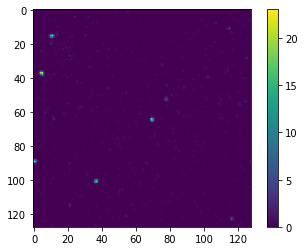

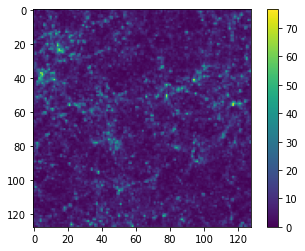

In [45]:
imshow(np.array(rho[0]).sum(axis=0))
colorbar()
show()
imshow(np.array(rho[1]).sum(axis=0))
colorbar()
show()

In [65]:
# Let's now build a function that returns a sampled power spectrum
PS = Power_Spectrum(shape=np.array([box_size, box_size, box_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=0.1,dk=.05)

@tf.function
def get_pk(halocat, logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06):
    k, pk = PS.pk_tf(sample(tf_halocat, logMmin=logMmin, sigma_logM=sigma_logM,
                            logM0=logM0, logM1=logM1, alpha=alpha))
    return k, pk

In [70]:
k, pk = get_pk(tf_halocat, 
             tf.convert_to_tensor([15.02,11.0]),
             tf.convert_to_tensor([0.26,0.22]), 
             tf.convert_to_tensor([10.0,11.]), 
             tf.convert_to_tensor([10.31,12.0]), 
             tf.convert_to_tensor([1.06,1.06]))

In [ ]:
loglog(k,pk[0], label='rec')
loglog(k,pk[1], label='rec')
legend()

In [73]:
# Let's just compute a diagonal cov (takes a while...)
import time
start_time = time.time()
samps = []
for i in range(50):
  k, pk = get_pk(tf_halocat, 
                logMmin=12.02*tf.ones([batch_size]),
                sigma_logM=0.26*tf.ones([batch_size]), 
                logM0=11.38*tf.ones([batch_size]), 
                logM1=13.31*tf.ones([batch_size]), 
                alpha=1.06*tf.ones([batch_size]))
  samps.append(pk)
end_time = time.time()- start_time
print(end_time)

196.84300637245178


In [74]:
samps = np.stack(samps, axis=0).reshape(100,-1)
diag_std = samps.std(axis=0)
diag_std.shape

(61,)

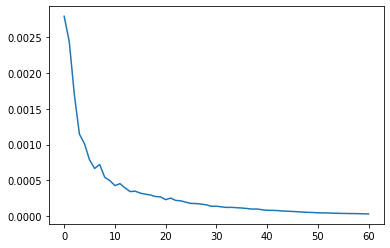

In [76]:
plot(diag_std)